### Training Pothole detector using YOLOV5

1. Downloading the YOLO V5 model files

2. Preparing the annotated files

3. Preparing the train, validation and test sets

4. Implementing the training process

5. Inference process using the trained model

In [6]:
import pandas as pd
import os
import glob
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import shutil
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
import PIL

In [ ]:
# Clone the repository in the folder you want to implement this project
!git clone https://github.com/ultralytics/yolov5


In [8]:
# Reading the csv file. Please change the path to your csv file
pothole_df = pd.read_csv('/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/pothole_df.csv')
pothole_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,pothole1.jpeg,275,183,pothole,64,78,130,107
1,pothole1.jpeg,275,183,pothole,44,105,131,154
2,pothole1.jpeg,275,183,pothole,12,151,59,177
3,pothole1.jpeg,275,183,vegetation,163,33,254,58
4,pothole1.jpeg,275,183,pothole,115,54,142,74


In [9]:
# First get the list of all classes
classes = pothole_df['class'].unique().tolist()
classes

['pothole', 'vegetation', 'sign', 'vehicle']

In [14]:
# Create a dictionary for storing class to ID mapping
classMap = {}
 
for i,cls in enumerate(classes):
    # Map a class name to an integet ID
    classMap[cls] = i
     
classMap

{'pothole': 0, 'vegetation': 1, 'sign': 2, 'vehicle': 3}

In [ ]:
# Create the main data folder
!mkdir potholeData
# Create images and labels data folders
!mkdir potholeData/images
!mkdir potholeData/labels
# Create train,val and test data folders for both images and labels
!mkdir potholeData/images/train potholeData/images/val potholeData/images/test  potholeData/labels/train potholeData/labels/val potholeData/labels/test


In [ ]:
# Creating the list of images from the excel sheet
imgs = pothole_df['filename'].unique().tolist()
# Loop through each of the image
for img in imgs:
    boundingDetails = []
    # First get the bounding box information for a particular image from the excel sheet
    boundingInfo = pothole_df.loc[pothole_df.filename == img,:]
    # Loop through each row of the details
    for idx, row in boundingInfo.iterrows():
        # Get the class Id for the row
        class_id = classMap[row["class"]]
        # Convert the bounding box info into the format for YOLOV5
        # Get the width
        bb_width = row['xmax'] - row['xmin']
        # Get the height
        bb_height = row['ymax'] - row['ymin']
        # Get the centre coordinates
        bb_xcentre = (row['xmin'] + row['xmax'])/2
        bb_ycentre = (row['ymin'] + row['ymax'])/2
        # Normalise the coordinates by diving by width and height
        bb_xcentre /= row['width'] 
        bb_ycentre /= row['height'] 
        bb_width    /= row['width'] 
        bb_height   /= row['height']  
        # Append details in the list 
        boundingDetails.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, bb_xcentre, bb_ycentre, bb_width, bb_height))
    # Create the file name to save this info     
    file_name = os.path.join("potholeData/labels", img.split(".")[0] + ".txt")
    # Save the annotation to disk
    print("\n".join(boundingDetails), file= open(file_name, "w"))


In [16]:
# Get the list of all annotations
annotations = glob.glob('potholeData/labels' + '/*.txt')
annotations

['potholeData/labels/pothole1.txt',
 'potholeData/labels/pothole10.txt',
 'potholeData/labels/pothole11.txt',
 'potholeData/labels/pothole12.txt',
 'potholeData/labels/pothole13.txt',
 'potholeData/labels/pothole14.txt',
 'potholeData/labels/pothole15.txt',
 'potholeData/labels/pothole16.txt',
 'potholeData/labels/pothole17.txt',
 'potholeData/labels/pothole18.txt',
 'potholeData/labels/pothole2.txt',
 'potholeData/labels/pothole3.txt',
 'potholeData/labels/pothole4.txt',
 'potholeData/labels/pothole5.txt',
 'potholeData/labels/pothole6.txt',
 'potholeData/labels/pothole7.txt',
 'potholeData/labels/pothole8.txt',
 'potholeData/labels/pothole9.txt']

In [12]:
# Get the list of images from its folder
imagePath = '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/data/annotatedImages'
images = glob.glob(imagePath + '/*.jpeg')
images

['/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/data/annotatedImages/pothole1.jpeg',
 '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/data/annotatedImages/pothole10.jpeg',
 '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/data/annotatedImages/pothole11.jpeg',
 '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/data/annotatedImages/pothole12.jpeg',
 '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/data/annotatedImages/pothole13.jpeg',
 '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/data/annotatedImages/pothole14.jpeg',
 '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/data/annotatedImages/pothole15.jpeg',
 '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/data/annotatedImages/pothole16.jpeg',
 '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/data/annotatedImages/pothole17.jpeg',
 '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/B

In [13]:
# Sort the annotations and images and the prepare the train ,test and validation sets
images.sort()
annotations.sort()
 
# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 123)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 123)

In [14]:
train_images

['/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/data/annotatedImages/pothole14.jpeg',
 '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/data/annotatedImages/pothole16.jpeg',
 '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/data/annotatedImages/pothole1.jpeg',
 '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/data/annotatedImages/pothole7.jpeg',
 '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/data/annotatedImages/pothole9.jpeg',
 '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/data/annotatedImages/pothole18.jpeg',
 '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/data/annotatedImages/pothole2.jpeg',
 '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/data/annotatedImages/pothole12.jpeg',
 '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Pothole/data/annotatedImages/pothole10.jpeg',
 '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/Baye

In [ ]:
#Utility function to copy images to destination folder
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

In [ ]:
# Copy the splits into the respective folders
move_files_to_folder(train_images, 'potholeData/images/train')
move_files_to_folder(val_images, 'potholeData/images/val/')
move_files_to_folder(test_images, 'potholeData/images/test/')
move_files_to_folder(train_annotations, 'potholeData/labels/train/')
move_files_to_folder(val_annotations, 'potholeData/labels/val/')
move_files_to_folder(test_annotations, 'potholeData/labels/test/')

In [15]:
glob.glob('potholeData/images/train' + '/*.jpeg')

['potholeData/images/train/pothole1.jpeg',
 'potholeData/images/train/pothole10.jpeg',
 'potholeData/images/train/pothole11.jpeg',
 'potholeData/images/train/pothole12.jpeg',
 'potholeData/images/train/pothole14.jpeg',
 'potholeData/images/train/pothole15.jpeg',
 'potholeData/images/train/pothole16.jpeg',
 'potholeData/images/train/pothole18.jpeg',
 'potholeData/images/train/pothole2.jpeg',
 'potholeData/images/train/pothole4.jpeg',
 'potholeData/images/train/pothole5.jpeg',
 'potholeData/images/train/pothole7.jpeg',
 'potholeData/images/train/pothole8.jpeg',
 'potholeData/images/train/pothole9.jpeg']

#### Creation of yaml file

Open the editor and copy the following lines and then save the file as potholeData.yaml. 

Please change the path of the train/val/test as per your correct path

In [ ]:
train: /BayesianQuest/Pothole/yolov5/potholeData/images/train/
val:  /BayesianQuest/Pothole/yolov5/potholeData/images/val/
test: /BayesianQuest/Pothole/yolov5/potholeData/images/test/
 
# number of classes
nc: 4
 
# class names
names: ["pothole","vegetation", "sign","vehicle"]

In [17]:
# Command for initiating the training process. You can also implement this on the terminal
!python train.py --img 640 --cfg yolov5m.yaml --hyp data/hyps/hyp.scratch-med.yaml --batch 4 --epochs 500 --data potholeData.yaml --weights yolov5m.pt --workers 4 --name yolo_pothole_det_m3

wandb: Currently logged in as: jmjtlbq (use `wandb login --relogin` to force relogin)
train: weights=yolov5m.pt, cfg=yolov5m.yaml, data=potholeData.yaml, hyp=data/hyps/hyp.scratch-med.yaml, epochs=500, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=4, project=runs/train, name=yolo_pothole_det_m3, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 22 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
/home/acer/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found ve

               Class     Images     Labels          P          R     mAP@.5 mAP@WARNING: NMS time limit 0.160s exceeded
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          2          3     0.0118      0.667      0.388     0.0388

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    22/499        0G    0.1044   0.04009   0.02635        23       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@WARNING: NMS time limit 0.160s exceeded
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          2          7    0.00452      0.375     0.0109    0.00109

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    23/499        0G   0.09888   0.04397   0.02468        12       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@WARNING: NMS time limit 0.160s exceede


     Epoch   gpu_mem       box       obj       cls    labels  img_size
    40/499        0G   0.09632   0.05034   0.02443        39       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@WARNING: NMS time limit 0.160s exceeded
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          2          7    0.00136      0.125    0.00215    0.00043

     Epoch   gpu_mem       box       obj       cls    labels  img_size
train: Scanning '/media/acer/7DC832E057A5BDB1/JMJTL/Tomslabs/BayesianQuest/Potho
    41/499        0G   0.07986   0.04113   0.02365        22       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@WARNING: NMS time limit 0.160s exceeded
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          2          7    0.00133      0.125    0.00127   0.000127

     Epoch   gpu_mem       box      


     Epoch   gpu_mem       box       obj       cls    labels  img_size
    77/499        0G   0.07914   0.04671   0.01837         8       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@WARNING: NMS time limit 0.160s exceeded
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          2          7    0.00611      0.292    0.00853    0.00208

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    78/499        0G   0.08599   0.04365   0.01987         9       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@WARNING: NMS time limit 0.160s exceeded
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          2          7    0.00611      0.292    0.00853    0.00208

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    79/499        0G   0.09299   0.04018    0.


     Epoch   gpu_mem       box       obj       cls    labels  img_size
    96/499        0G   0.08788    0.0342    0.0213        18       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@WARNING: NMS time limit 0.160s exceeded
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          2          7    0.00849      0.417     0.0117    0.00135

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    97/499        0G   0.08243   0.04123   0.01923        12       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@WARNING: NMS time limit 0.160s exceeded
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          2          7    0.00693      0.292     0.0118    0.00267

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    98/499        0G    0.0817   0.04357   0.0


     Epoch   gpu_mem       box       obj       cls    labels  img_size
   115/499        0G   0.07619    0.0498    0.0176        10       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@WARNING: NMS time limit 0.160s exceeded
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          2          7     0.0109      0.458     0.0506     0.0105

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   116/499        0G   0.07804   0.04188   0.01918         8       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@WARNING: NMS time limit 0.160s exceeded
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all          2          7     0.0109      0.458     0.0506     0.0105

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   117/499        0G   0.07615   0.04101   0.0

In [23]:
# Command for implementing the infrence process. Please remember to change the path for the weights of the model and source of your test files
!python detect.py --source potholeData/images/val/ --weights runs/train/yolo_pothole_det_m/weights/best.pt --max-det 3  --conf-thres 0.005 --classes 0 --name yolo_pothole_det_test_m

detect: weights=['runs/train/yolo_pothole_det_m3/weights/best.pt'], source=potholeData/images/val/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.005, iou_thres=0.45, max_det=3, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=[0, 1], agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_pothole_det_test_m1, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
/home/acer/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUD

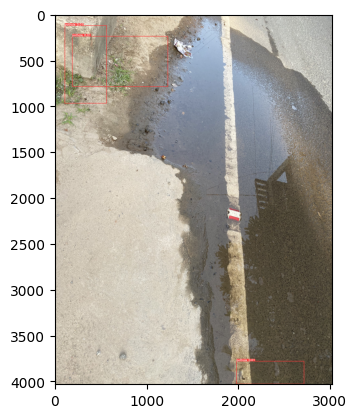

In [33]:
detections_dir = "runs/detect/yolo_pothole_det_test_m2/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = PIL.Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))
plt.show()